# Alternative Calendar Visualizations

This notebook was used for testing alternative visualization methods, such as different locations (New York) as well as aggregating multiple year's worth of data to create the visualiztion for a system that gets progressively smaller.

### Copying over some of the code used for calendar visualization to visualize some other locations/normalization methods

In [43]:
# Importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"

# Cleaning off first row and units
def clean_units(df):
    units_list = df.iloc[0]
    df = df.iloc[1:]

    # Cleaning units
    df = df.apply(pd.to_numeric)

    return df, units_list


This is a stopgap method to get decreasing system sizes: here, combining three year's worth of data even though it is really just one year repeated with different sizings. This is creating a minor visual bug where the Weekdays at the beginning and end of the years do not match up exactly.

In [57]:
# Importing and combining all datasets to get three yearly subplots
atx_45t25b_df = pd.read_csv('BEopt Viz\\atx_45t25b.csv')
atx_3t15b_df = pd.read_csv('BEopt Viz\\atx_3t15b.csv')
atx_15t10b_df = pd.read_csv('BEopt Viz\\atx_15t10b.csv')
atx_45t25b_df, units = clean_units(atx_45t25b_df)
atx_3t15b_df, units = clean_units(atx_3t15b_df)
atx_15t10b_df, units = clean_units(atx_15t10b_df)

atx_df = pd.concat([atx_45t25b_df, atx_3t15b_df, atx_15t10b_df])

# Slicing out only wanted columns and labels and changing to datetime
full_labels_list = atx_df.columns.tolist()

living_space_columns = ['My Design - Temperature| Living Space', 'My Design - Temperature| Heating Setpoint', 'My Design - Temperature| Cooling Setpoint']
short_labels = ['living_space_temp', 'heating_setpoint', 'cooling_setpoint'] #temps in F
# Creating date range
date_range = pd.date_range(start="2021-01-01", end="2024-01-01", freq="1H", inclusive="left")

living_df = (atx_df[living_space_columns].set_axis(short_labels, axis=1) # slicing and renaming columns
                                         .set_index(date_range))         # changing to hourly index
            
living_df

C:\Users\micha.DESKTOP-U2HVTMF\AppData\Local\Temp\ipykernel_11364\4239136166.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82) have mixed types. Specify dtype option on import or set low_memory=False.
  atx_45t25b_df = pd.read_csv('BEopt Viz\\atx_45t25b.csv')
C:\Users\micha.DESKTOP-U2HVTMF\AppData\Local\Temp\ipykernel_11364\4239136166.py:3: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82) have mixed types. Specify dtype option on import or set low_memory=False.
  atx_3t15b_df = pd.read_csv('BEopt Viz\\atx_3t15b.csv')
C:\Users\micha.DESKTOP-U2HVTMF\AppData\Local

,living_space_temp,heating_setpoint,cooling_setpoint
2021-01-01 00:00:00,72.0,72,74
2021-01-01 01:00:00,72.0,72,74
2021-01-01 02:00:00,72.0,72,74
2021-01-01 03:00:00,72.0,72,74
2021-01-01 04:00:00,72.0,72,74
...,...,...,...
2023-12-31 19:00:00,74.0,72,74
2023-12-31 20:00:00,74.0,72,74
2023-12-31 21:00:00,74.0,72,74
2023-12-31 22:00:00,74.0,72,74


In [58]:
# Adding columns: deviation over/under the heating/cooling setpoint

setpoint_diff = living_df['cooling_setpoint'] - living_df['heating_setpoint']
living_df['heating_deviation'] = living_df['living_space_temp'] - living_df['heating_setpoint']
living_df['cooling_deviation'] = living_df['living_space_temp'] - living_df['cooling_setpoint']

# True if the temperature is below the heating setpoint or above the cooling setpoint.
living_df['exceeds_setpoints'] = np.where((living_df['living_space_temp'] > living_df['cooling_setpoint']) | (living_df['living_space_temp']<living_df['heating_setpoint']), True, False)

# Slicing a dataframe with timepoints that exceed the temperature setpoints
#excess_df = living_df[living_df['exceeds_setpoints'] == True]

# Make new column for too hot, to cold, or in range
range_conditions = [living_df['living_space_temp'] < living_df['heating_setpoint'], living_df['living_space_temp'] > living_df['cooling_setpoint'], (living_df['living_space_temp'].between(living_df['heating_setpoint'], living_df['cooling_setpoint']))]
range_choices = ['Too Cold', 'Too Hot', 'In Range']
living_df['in_range'] = np.select(range_conditions, range_choices)

# Make new column for amount of excess degrees, 0 if within comfortable range.
excess_conditions = [living_df['in_range'] == 'Too Hot', living_df['in_range'] == 'Too Cold', living_df['in_range'] == 'In Range']
excess_choices = [living_df['cooling_deviation'], living_df['heating_deviation'], 0]
living_df['excess_temp'] = np.select(excess_conditions, excess_choices)

too_hot_df = living_df[living_df['in_range'] == 'Too Hot'] # If exceeds, cooling_deviation is magnitude
too_cold_df = living_df[living_df['in_range'] == 'Too Cold'] # If exceeds, heating_deviation is magnitude

In [62]:
living_df

,living_space_temp,heating_setpoint,cooling_setpoint,heating_deviation,cooling_deviation,exceeds_setpoints,in_range,excess_temp
2021-01-01 00:00:00,72.0,72,74,0.0,-2.0,False,In Range,0.0
2021-01-01 01:00:00,72.0,72,74,0.0,-2.0,False,In Range,0.0
2021-01-01 02:00:00,72.0,72,74,0.0,-2.0,False,In Range,0.0
2021-01-01 03:00:00,72.0,72,74,0.0,-2.0,False,In Range,0.0
2021-01-01 04:00:00,72.0,72,74,0.0,-2.0,False,In Range,0.0
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,74.0,72,74,2.0,0.0,False,In Range,0.0
2023-12-31 20:00:00,74.0,72,74,2.0,0.0,False,In Range,0.0
2023-12-31 21:00:00,74.0,72,74,2.0,0.0,False,In Range,0.0
2023-12-31 22:00:00,74.0,72,74,2.0,0.0,False,In Range,0.0


In [59]:
import datetime as dt

# Condensing to day by day. Aggregating by excess minimum and maximum temperature.
living_dod_df = living_df.reset_index().rename(columns={'index': 'datetime'})
high_low_df = living_dod_df.groupby([living_dod_df['datetime'].dt.date]).agg({'excess_temp': [np.min, np.max]})

high_low_df['excess_high_low'] = high_low_df['excess_temp']['amin'] + high_low_df['excess_temp']['amax'] #TODO: doesn't account for edge case day exceeds both heating and cooling

# Aggregating the rest of the dataframe by mean temperature for that day and adding column.
living_dod_df = living_dod_df.groupby([living_dod_df['datetime'].dt.date]).mean()
living_dod_df['excess_high_low'] = high_low_df['excess_high_low']
living_dod_df

excess_df = living_dod_df[living_dod_df['exceeds_setpoints'] != 0]

C:\Users\micha.DESKTOP-U2HVTMF\AppData\Local\Temp\ipykernel_11364\1742728942.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  living_dod_df = living_dod_df.groupby([living_dod_df['datetime'].dt.date]).mean()


In [63]:
excess_df

,living_space_temp,heating_setpoint,cooling_setpoint,heating_deviation,cooling_deviation,exceeds_setpoints,excess_temp,excess_high_low
datetime,,,,,,,,
2021-01-12,72.002083,72.0,74.0,0.002083,-1.997917,0.041667,-0.001250,-0.03
2021-01-14,72.699167,72.0,74.0,0.699167,-1.300833,0.041667,-0.000833,-0.02
2021-01-16,72.366667,72.0,74.0,0.366667,-1.633333,0.041667,0.000833,0.02
2021-01-25,73.495417,72.0,74.0,1.495417,-0.504583,0.041667,0.000833,0.02
2021-01-31,72.914167,72.0,74.0,0.914167,-1.085833,0.041667,-0.001667,-0.04
...,...,...,...,...,...,...,...,...
2023-12-19,68.686667,72.0,74.0,-3.313333,-5.313333,1.000000,-3.313333,-6.41
2023-12-20,72.040417,72.0,74.0,0.040417,-1.959583,0.458333,-0.595417,-1.95
2023-12-21,72.848333,72.0,74.0,0.848333,-1.151667,0.083333,-0.002917,-0.06


### Creating progressively decreasing sized calendar visualizations - all on 2023, years are just for concatenation

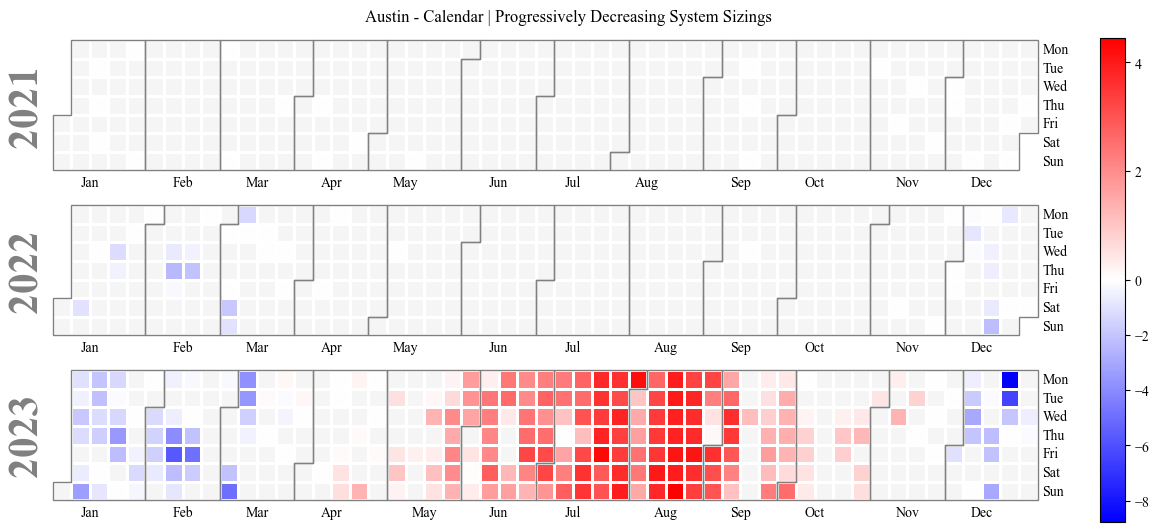

In [69]:
import calplot
from  matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm, CenteredNorm

# Creating custom color map to place white at 0 value.
cmap_min = excess_df['excess_high_low'].min()
cmap_max = excess_df['excess_high_low'].max()
ts_norm = TwoSlopeNorm(vmin = cmap_min, vcenter = 0, vmax = cmap_max)

excess_df.index = pd.to_datetime(excess_df.index)

# Plotting excess days on calendar heatmap, centered norm
calplot.calplot(excess_df['excess_high_low'],suptitle = 'Austin - Calendar | Progressively Decreasing System Sizings', norm=ts_norm, cmap = 'bwr')
plt.savefig('Viz_Outputs\\aus_cal_decreasing_size.pdf', bbox_inches='tight')